In [1]:
import pandas as pd
import sklearn
import numpy as np
import util
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pydotplus
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dtreeviz.trees import dtreeviz
import lightgbm as lgb

In [3]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm 
import matplotlib.pylab as plt 
from dmba import regressionSummary, exhaustive_search 
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.metrics import r2_score
from dmba import backward_elimination, forward_selection

In [4]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 81)

In [5]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)
#feature = pd.read_csv('Data/Created Datasets/KSI_Feature_Collapse.csv', index_acol = 0)
#count = pd.read_csv('Data/Created Datasets/KSI_Collapse_Count_truncate3.csv')

In [54]:
# dataset without hazardous dataset - this dataset is bigger

ultimate_df = pd.read_csv('Data/Created Datasets/Impediments_Feature_Count.csv', index_col = 0)

In [55]:
# only downtown

ultimate_df = ultimate_df[(ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700)]

In [36]:
# not downtown

ultimate_df = ultimate_df[~((ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700))]

In [6]:
ultimate_df['LIGHT'] = ultimate_df['LIGHT'].apply(util.lc)
ultimate_df['TRAFFCTL'] = ultimate_df['TRAFFCTL'].apply(util.tc)
ultimate_df['DRIVACT'] = ultimate_df['DRIVACT'].apply(util.actc)
ultimate_df['DRIVCOND'] = ultimate_df['DRIVCOND'].apply(util.condc)
ultimate_df['VEHTYPE'] = ultimate_df['VEHTYPE'].apply(util.vehc)
ultimate_df['INVAGE'] = ultimate_df['INVAGE'].apply(util.agec)
#ultimate_df['MANOEUVER'] = ultimate_df['MANOEUVER'].apply(util.manc)

In [28]:
print(ultimate_df['DRIVCOND'].unique())
print(ultimate_df['DRIVACT'].unique())
print(ultimate_df['LIGHT'].unique())
print(ultimate_df['TRAFFCTL'].unique())
print(ultimate_df['VEHTYPE'].unique())
print(ultimate_df['INVAGE'].unique())
#print(ultimate_df['MANOEUVER'].unique())

['Normal' 'Inattentive' '<Null>' 'Ability Impaired (Drugs/Alcohol)'
 'Unknown' 'Medical or Physical Disability' 'Other' 'Fatigue']
['Improper Turn' 'Failed to Yield Right of Way' '<Null>' 'Lost control'
 'Improper Passing' 'Disobeyed Traffic Control' 'Improper Lane Change'
 'Speed too Fast For Condition' 'Speeding' 'Following too Close' 'Other'
 'Wrong Way on One Way Road']
['Daylight' 'Artificial' 'Dark' 'Dusk' 'Dawn']
['Traffic Signal' 'No Control' 'Stop/Yield Sign' 'Streetcar (Stop for)'
 'Controller present' 'Pedestrian Crossover']
['Small-size Vehicle' 'Two Wheeler' 'Large-size Vehicle'
 'Medium-size Vehicle' 'Other']
['Adult' 'Senior' 'Super Senior' 'Young Adult' 'Children']


In [7]:
ultimate_df = ultimate_df.replace('Yes', 1).replace('<Null>', 0).replace('<Null', 0)

In [8]:
ultimate_df['TIME'] = round(ultimate_df['TIME']/100,3)
#ultimate_df.head()

In [96]:
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude',  'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV', 'PercentOther')]]

X = pd.get_dummies(X, drop_first = True)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]

In [10]:
X.shape

(706, 49)

In [88]:
# ONLY RUN THESE FOR LIGHTGBM

X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude',  'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV', 'PercentOther')]]

#X = pd.get_dummies(X)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]

# ABSOLUTELY IMPORTANT STEP

for c in X.columns:
     col_type = X[c].dtype
     if col_type == 'object' or col_type.name == 'category':
         X[c] = X[c].astype('category')
         X[c] = X[c].cat.codes


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [97]:
Y = ultimate_df['COUNT']

train_X, valid_X, train_Y, valid_Y =  train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [12]:
# Does the model perform better than the null model?
# Our created models must be able to beat this:
# I'm comparing valid_Y to the mean of COUNT. 

regressionSummary(valid_Y, np.repeat(Y.mean(), valid_Y.shape))


Regression statistics

                      Mean Error (ME) : 0.1343
       Root Mean Squared Error (RMSE) : 2.1135
            Mean Absolute Error (MAE) : 1.6914
          Mean Percentage Error (MPE) : -54.8264
Mean Absolute Percentage Error (MAPE) : 86.1793


In [19]:
param_grid = { 
 'max_depth': [3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
 'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001], 
 'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005] 
} 

In [98]:
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state = 1), param_grid, cv = 5, n_jobs = -1)
gridSearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001],
                         'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005]})

In [99]:
gridSearch.best_estimator_

DecisionTreeRegressor(max_depth=9, min_impurity_decrease=0.01,
                      min_samples_split=0.01, random_state=1)

In [19]:
# this creates a unique looking dctree with distributions of variables and the split shown

viz = dtreeviz(gridSearch.best_estimator_, valid_X, valid_Y,
               target_name="COUNT",
               feature_names= valid_X.columns,
               title="test")

viz.save("decision_tree_wine.svg")

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
Mean of empty slice.
invalid value encountered in double_scalars


In [380]:
# this creates a LARGE dctree visual - DON'T RUN otherwise

import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(gridSearch.best_estimator_, 
                           feature_names=valid_X.columns, 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
#graph

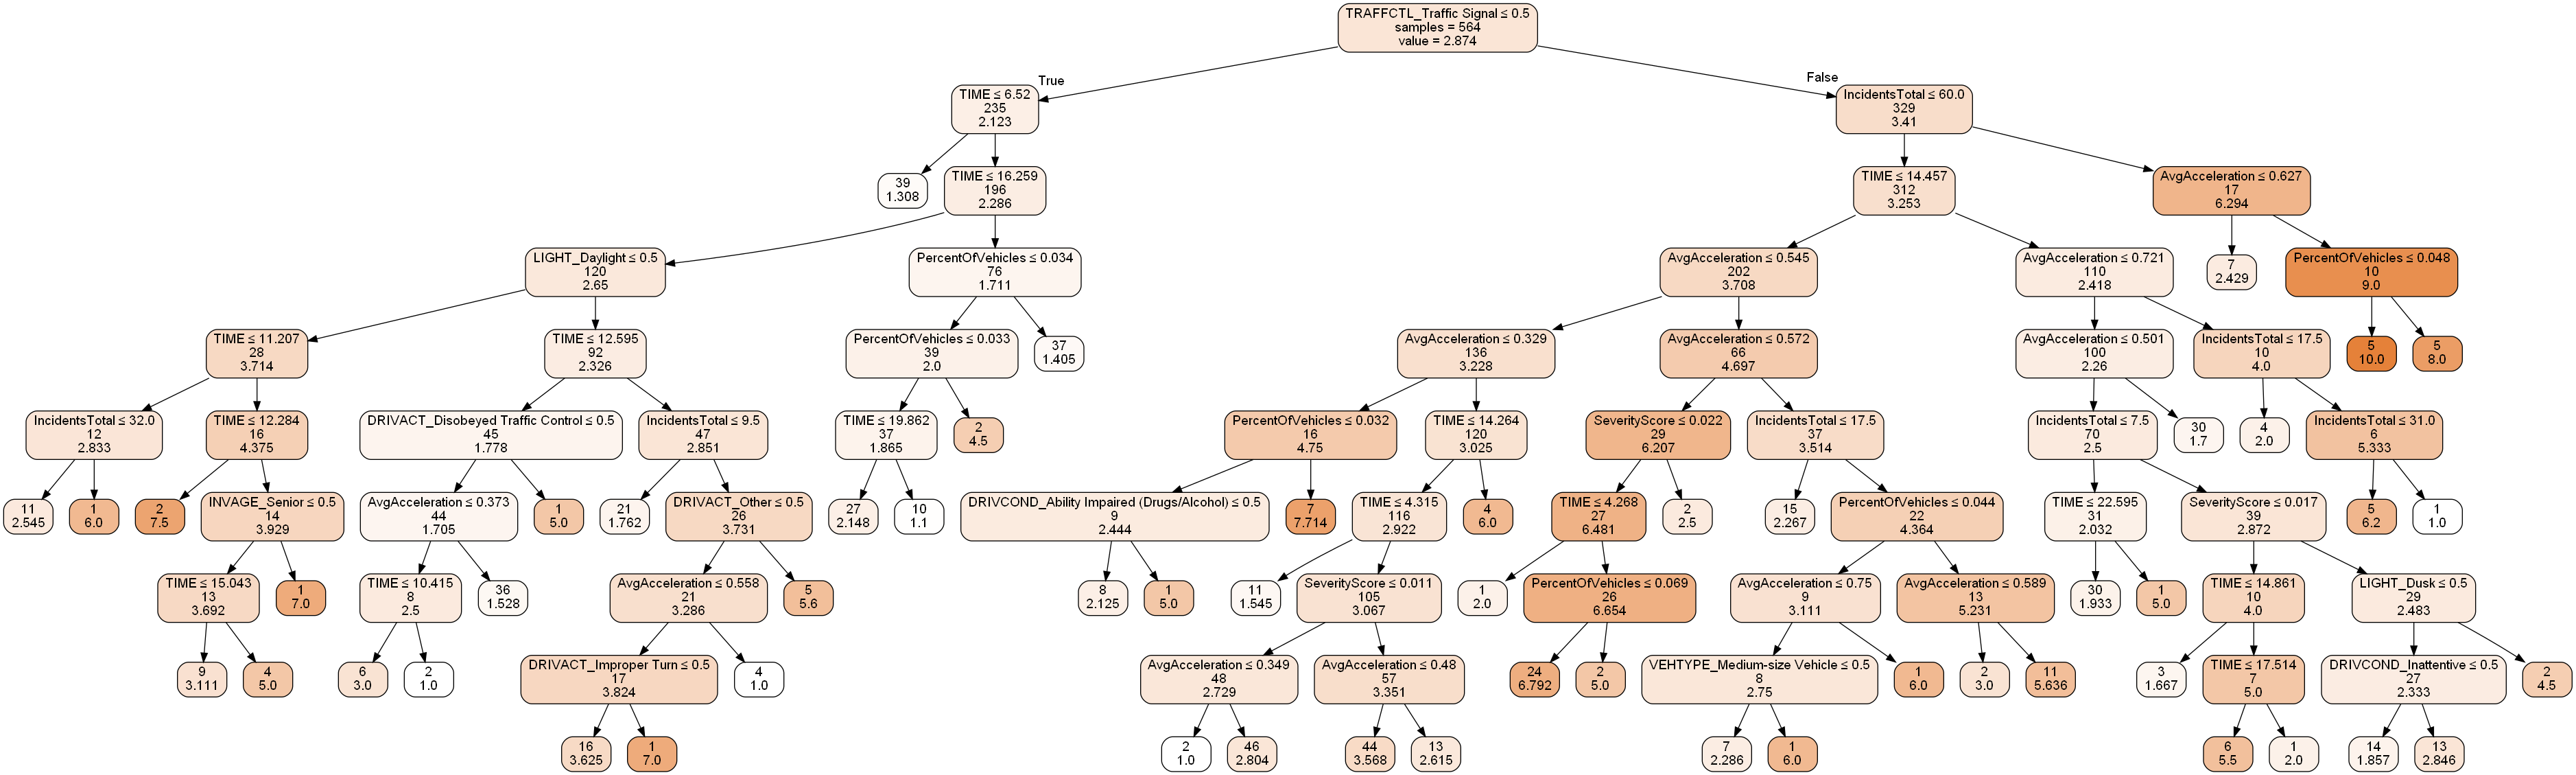

In [100]:
plotDecisionTree(gridSearch.best_estimator_, train_X.columns)

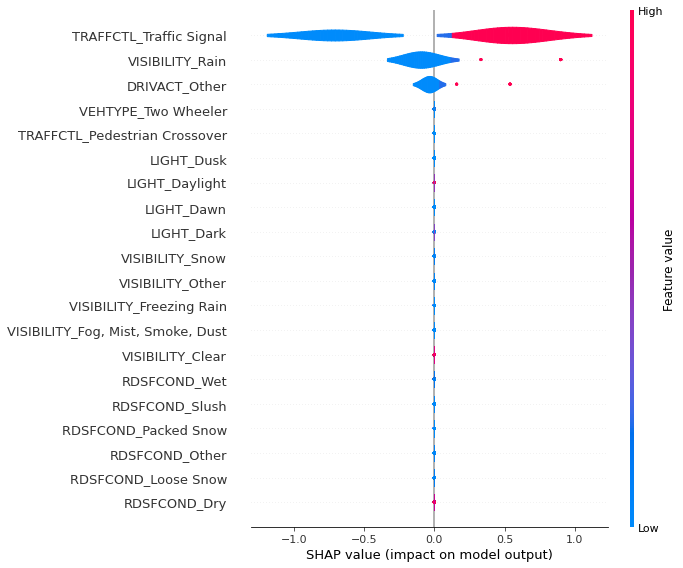

In [29]:
explainer = shap.TreeExplainer(gridSearch.best_estimator_)
shap_values = explainer.shap_values(valid_X)
shap.summary_plot(shap_values, valid_X, plot_type = 'violin')

In [101]:
print(regressionSummary(train_Y, gridSearch.best_estimator_.predict(train_X)))
regressionSummary(valid_Y, gridSearch.best_estimator_.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.7991
            Mean Absolute Error (MAE) : 0.6055
          Mean Percentage Error (MPE) : -14.7179
Mean Absolute Percentage Error (MAPE) : 32.6757
None

Regression statistics

                      Mean Error (ME) : -0.0443
       Root Mean Squared Error (RMSE) : 1.6704
            Mean Absolute Error (MAE) : 1.0584
          Mean Percentage Error (MPE) : -32.0788
Mean Absolute Percentage Error (MAPE) : 58.5519


In [90]:
fit_params={
            "eval_metric" : 'l2', 
            "eval_set" : [(valid_X, valid_Y), (train_X, train_Y)],
            'eval_names': ['valid','train'],
            'feature_name': 'auto', 
            'categorical_feature': X.select_dtypes("int8").columns.tolist()
           }
           
lgbreg = lgb.LGBMRegressor(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='l2', 
                         n_jobs= -1, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1,
                         )


lgbreg.fit(train_X, train_Y, **fit_params)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is ['DRIVACT', 'DRIVCOND', 'INVAGE', 'LIGHT', 'RDSFCOND', 'TRAFFCTL', 'VEHTYPE', 'VISIBILITY']
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[1]	train's l2: 3.55281	valid's l2: 4.11351
[2]	train's l2: 3.2795	valid's l2: 3.82224
[3]	train's l2: 3.05007	valid's l2: 3.58066
[4]	train's l2: 2.87428	valid's l2: 3.38915
[5]	train's l2: 2.66195	valid's l2: 3.21935
[6]	train's l2: 2.4846	valid's l2: 3.06507
[7]	train's l2: 2.31693	valid's l2: 2.93166
[8]	train's l2: 2.18979	valid's l2: 2.82348
[9]	train's l2: 2.10232	valid's l2: 2.75011
[10]	train's l2: 1.98304	valid's l2: 2.64255
[11]	train's l2: 1.88513	valid's l2: 2.55337
[12]	train's l2: 1.79537	valid's l2: 2.47037
[13]	train's l2: 1.72641	valid's l2: 2.39781
[14]	train's l2: 1.64824	valid's l2: 2.36083
[15]	train's l2: 1.5724	valid's l2: 2.30703
[16]	train's l2: 1.51764	valid's l2: 2.24387
[17]	train's l2: 1.4637	valid's l2: 2.21176
[18]	train's l2: 1.41067	valid's l2: 2.18753
[19]	train's l2: 1.36592	valid's l2: 2.15298
[20]	train's l2: 1.31214	valid's l2: 2.0947
[21]	train's l2: 1.27181	valid's l2: 2.04788
[22]	train's l2: 1.23178	valid's l2: 2.02903
[23]	train's l2: 1.16729

LGBMRegressor(colsample_bytree=0.9, metric='l2', n_estimators=1000,
              num_leaves=15, random_state=314, silent=True, subsample=0.9)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

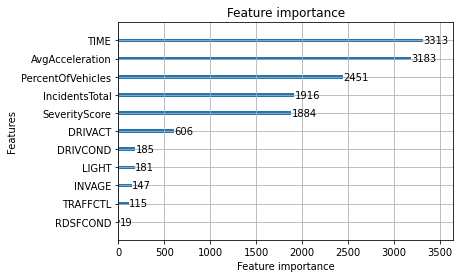

In [91]:
lgb.plot_importance(lgbreg)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

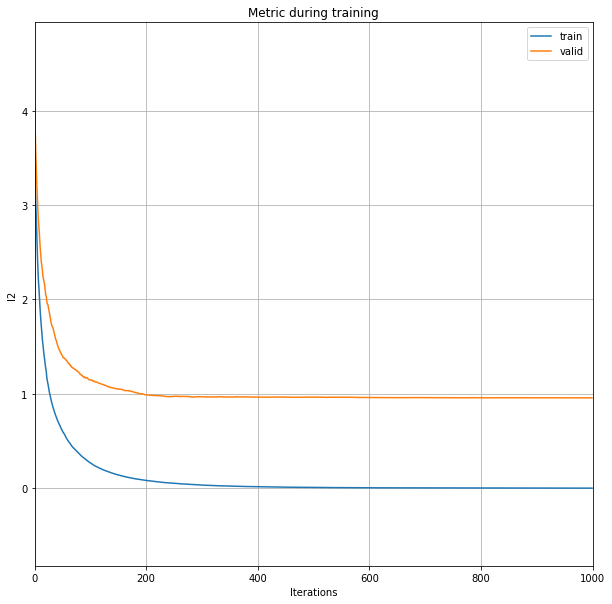

In [92]:
lgb.plot_metric(lgbreg, figsize = (10,10))

In [93]:
X['TRAFFCTL']

0      5
1      5
2      5
3      5
4      5
      ..
701    5
702    1
703    5
704    5
705    5
Name: TRAFFCTL, Length: 706, dtype: int8

<AxesSubplot:>

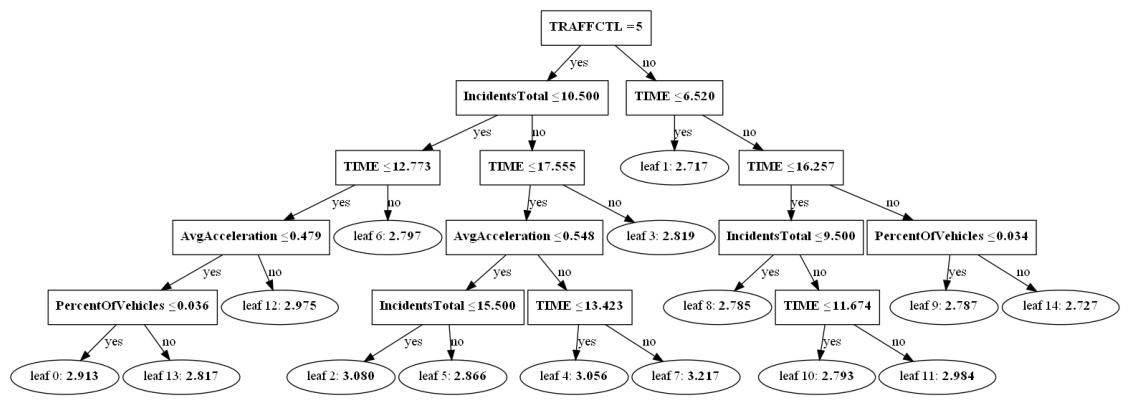

In [94]:
lgb.plot_tree(lgbreg, orientation = 'vertical', figsize=(20,20))

In [95]:
print(regressionSummary(train_Y, lgbreg.predict(train_X)))
regressionSummary(valid_Y, lgbreg.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.0258
            Mean Absolute Error (MAE) : 0.0174
          Mean Percentage Error (MPE) : -0.1220
Mean Absolute Percentage Error (MAPE) : 0.7684
None

Regression statistics

                      Mean Error (ME) : -0.0650
       Root Mean Squared Error (RMSE) : 0.9782
            Mean Absolute Error (MAE) : 0.7241
          Mean Percentage Error (MPE) : -22.9107
Mean Absolute Percentage Error (MAPE) : 43.9061


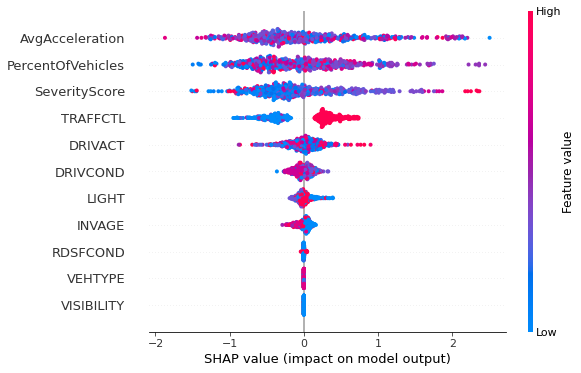

In [87]:
explainer = shap.Explainer(lgbreg)
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, train_X)

In [30]:
rf = RandomForestRegressor(n_estimators = 2000, random_state = 1) 
rf.fit(train_X, train_Y)

RandomForestRegressor(n_estimators=2000, random_state=1)

Text(0.5, 1.0, 'Visualizing Important Features')

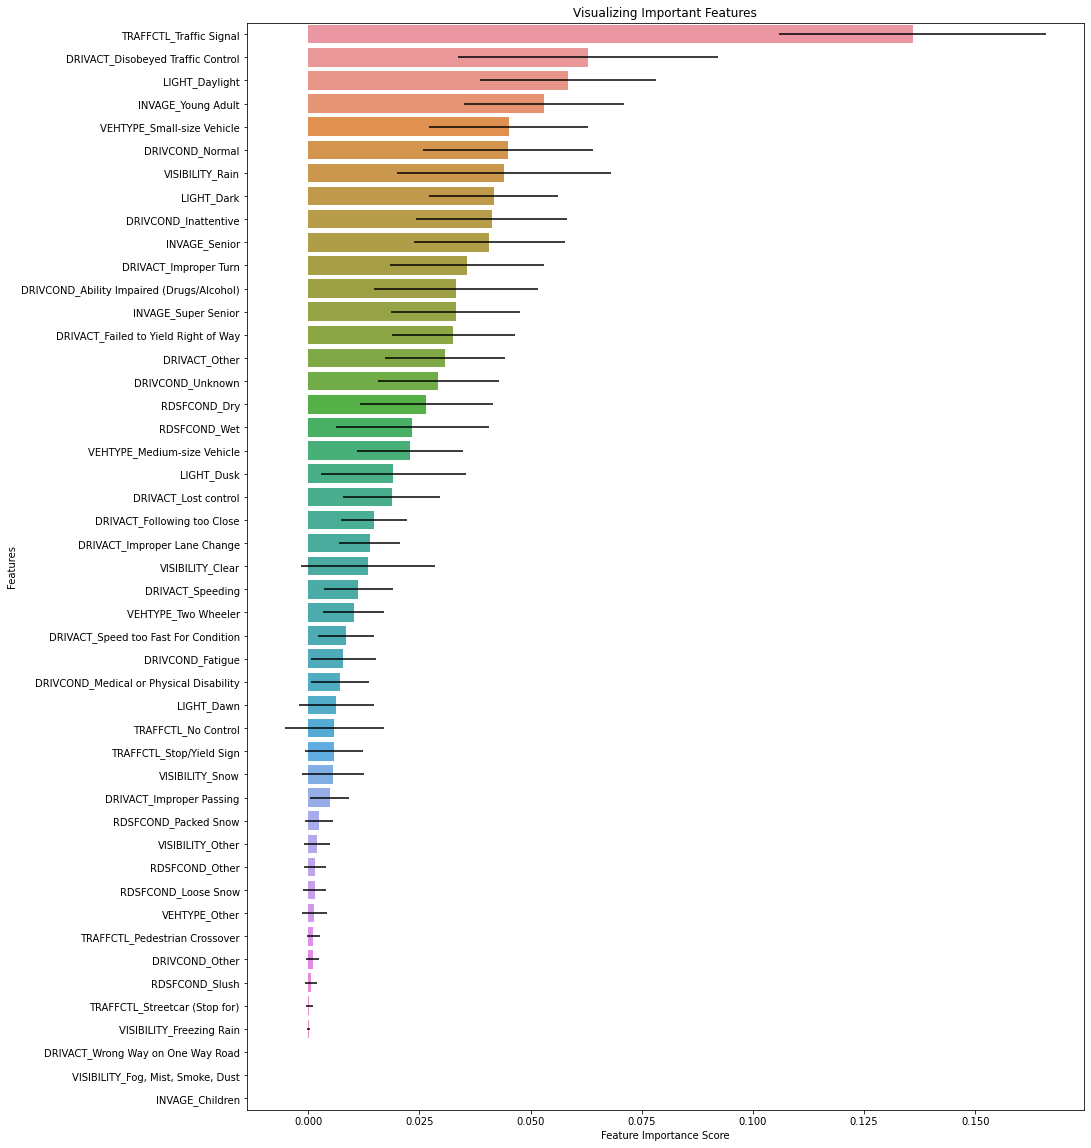

In [31]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0) 
tf = pd.DataFrame({'feature': train_X.columns, 'importance': rf.feature_importances_, 'std': std}) 
tf = tf.sort_values('importance', ascending = False)
plt.figure(figsize = (15,20))
sns.barplot(x = tf['importance'], y = tf['feature'], xerr = tf['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [32]:
print(regressionSummary(train_Y, rf.predict(train_X)))
regressionSummary(valid_Y, rf.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0146
       Root Mean Squared Error (RMSE) : 1.2038
            Mean Absolute Error (MAE) : 0.8551
          Mean Percentage Error (MPE) : -24.9526
Mean Absolute Percentage Error (MAPE) : 41.1790
None

Regression statistics

                      Mean Error (ME) : -0.0902
       Root Mean Squared Error (RMSE) : 2.2428
            Mean Absolute Error (MAE) : 1.7235
          Mean Percentage Error (MPE) : -57.5110
Mean Absolute Percentage Error (MAPE) : 87.3853


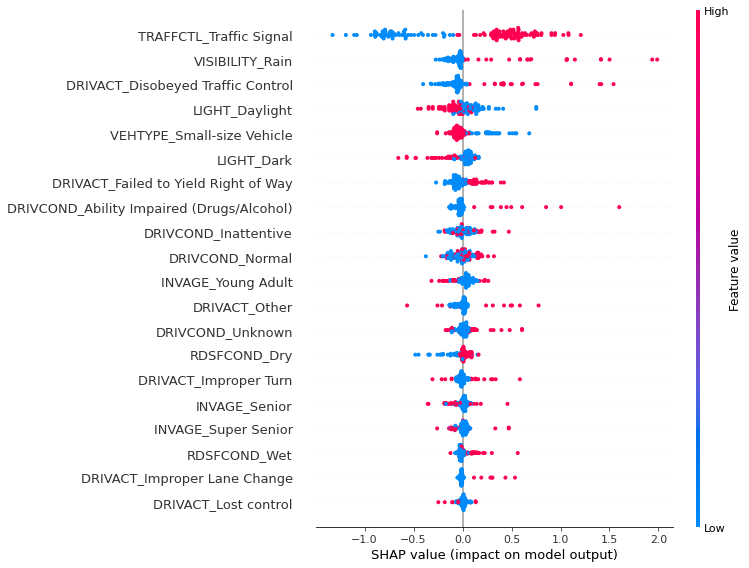

In [33]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(valid_X)
shap.summary_plot(shap_values, valid_X)